# Usage Example: Single Trace

This notebook describes the analysis of a single, semi-synthetic trace. The functions called in this notebook are more low-level and probably not your best choice if you just want to analyse traces. The notebook analysis_stack should help you do that. This notebook is intended to provide a better understanding of how the algorithm works, and how to set the threshold parameter in the analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import quickpbsa as pbsa

%matplotlib inline

## Build a trace from less complex traces

The first step is to build a complex trace from traces which can still be easily analysed by eye. In this case two traces with 3 bleaching steps each and one with 4 bleaching steps are summed up. Thus the resulting trace has 10 bleaching steps.

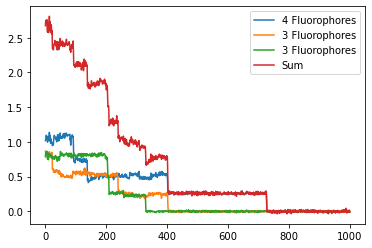

In [2]:
traces=np.loadtxt('./Data/ExampleTrace.txt')
sumtrace=np.sum(traces,0)

plt.figure()
plt.plot(traces.T)
plt.plot(sumtrace)
plt.legend(['4 Fluorophores','3 Fluorophores','3 Fluorophores','Sum'])
plt.show()

#reverse trace
sumtrace=np.flipud(sumtrace)

## Preliminary Step Detection

First we run the preliminary step detection on the reversed trace with a threshold setting of 0.1, roughly half of the height of the last step. The preliminary step detection successively places steps in the trace, while evaluating the Schwarz information criterion. Steps with a difference in means below the threshold are not added.  

Finished after 29 iterations


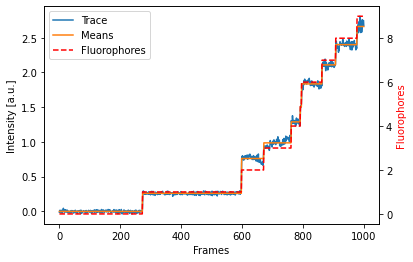

In [24]:
# preliminary step detection
steppos,means,variances,posbysic,niter=pbsa.steps_preliminary.kv_single_fast(sumtrace,0.1,100)
print('Finished after ' + str(niter) + ' iterations')

# diffs are the numbers of frames between steps
diffs = np.diff(np.hstack([0, steppos, len(sumtrace)]))
# calculate mean trace 
meantrace = np.repeat(means, diffs)
# calculate fluorophores when counting every step with single occupancy
fluors = np.cumsum(np.hstack((0, np.sign(np.diff(means)))))
fluortrace = np.repeat(fluors, diffs)

fig = plt.figure()
plt.plot(sumtrace, label='Trace')
plt.plot(meantrace, label='Means')
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_xlabel('Frames')
ax1.set_ylabel('Intensity [a.u.]')
ax2.plot(fluortrace, 'r--', label='Fluorophores')
ax2.set_ylabel('Fluorophores', color='r')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

The preliminary step detection appears to detect all steps from the original traces. But since the preliminary step does not assign occupancies to the events, the number of fluorophores is underestimated by 1.

## Step Refinement

The main idea is to minimize the posterior iteratively, as detailed in the paper and the readme.

The step refinement will attempt to place steps with multiple occupancy, i.e. where more than one fluorophore bleaches in the same frame, starting from the result of the preliminary step detection. It will then successively remove steps in the inverse order in which they were found in the preliminary step detection, each time re-evaluating the occupancies and calculating the minimum posterior.

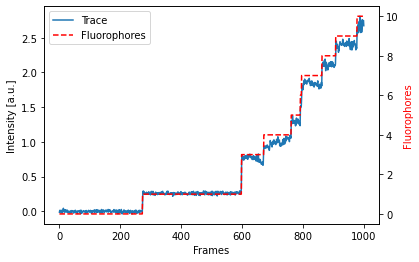

In [25]:
# call to improve_steps_single
success, sicmin, steppos_out, step_out = \
    pbsa.steps_refinement.improve_steps_single(sumtrace, steppos, means, variances, posbysic)

# calculate fluorophore trace
diffs = np.diff(np.hstack([0, steppos_out, len(sumtrace)]))
fluors = np.cumsum(np.hstack([0, step_out]))
fluortrace_final = np.repeat(fluors, diffs)

fig = plt.figure()
plt.plot(sumtrace, label='Trace')
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_xlabel('Frames')
ax1.set_ylabel('Intensity [a.u.]')
ax2.plot(fluortrace_final, 'r--', label='Fluorophores')
ax2.set_ylabel('Fluorophores', color='r')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

The step refinement correctly identifies the double step and the result now yields the correct number of 10 fluorophores.

## Setting the Threshold

Now let's explore a bit how the setting of the threshold parameter affects the analysis result. This is the most important parameter for the analysis and there is some danger of tuning results with the parameter.

### Threshold to low

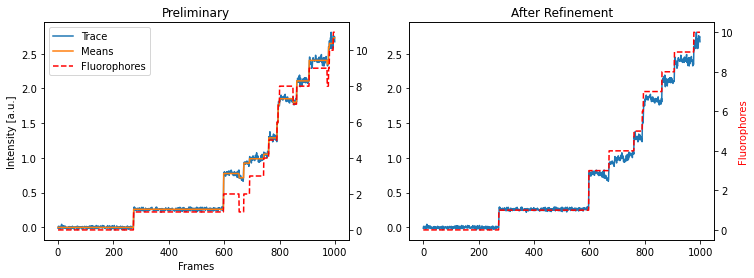

In [16]:
# preliminary step detection
steppos,means,variances,posbysic,niter=pbsa.steps_preliminary.kv_single_fast(sumtrace,0.05,100)

# diffs are the numbers of frames between steps
diffs = np.diff(np.hstack([0, steppos, len(sumtrace)]))
# calculate mean trace 
meantrace = np.repeat(means, diffs)
# calculate fluorophores when counting every step with single occupancy
fluors = np.cumsum(np.hstack((0, np.sign(np.diff(means)))))
fluortrace = np.repeat(fluors, diffs)

fig, axes = plt.subplots(1,2)
axes[0].set_title('Preliminary')
axes[0].plot(sumtrace, label='Trace')
axes[0].plot(meantrace, label='Means')
ax2 = axes[0].twinx()
axes[0].set_xlabel('Frames')
axes[0].set_ylabel('Intensity [a.u.]')
ax2.plot(fluortrace, 'r--', label='Fluorophores')
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# call to improve_steps_single
success, sicmin, steppos_out, step_out = \
    pbsa.steps_refinement.improve_steps_single(sumtrace, steppos, means, variances, posbysic)

# calculate fluorophore trace
diffs = np.diff(np.hstack([0, steppos_out, len(sumtrace)]))
fluors = np.cumsum(np.hstack([0, step_out]))
fluortrace_final = np.repeat(fluors, diffs)

axes[1].set_title('After Refinement')
axes[1].plot(sumtrace)
ax2 = axes[1].twinx()
ax2.plot(fluortrace_final, 'r--')
ax2.set_ylabel('Fluorophores', color='r')
fig.set_size_inches([12, 4])
plt.show()

If the threshold is set too low, the preliminary step detection will place spurious steps at positions of smaller signal fluctuations, something that happens frequently in experimental data. Small blinking events, often caused by photophysics of fluorophores, are detected as full bleaching events, e.g. around 700 frames.  
This is however corrected to a certain degree by the step refinement, since steps can be removed in the refinement. In the case of the example trace, all spurious steps or small blinking events are removed and the result from the previous threshold setting (10 fluorophores) is recovered.

### Threshold too high

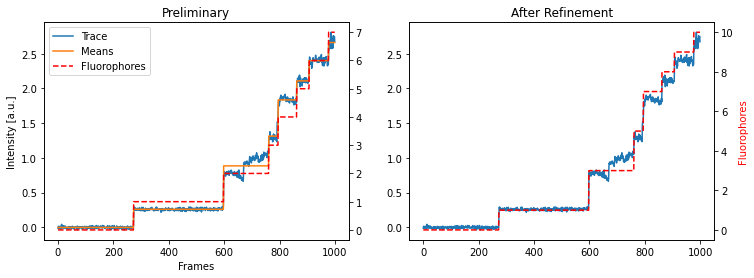

In [19]:
# preliminary step detection
steppos,means,variances,posbysic,niter=pbsa.steps_preliminary.kv_single_fast(sumtrace,0.25,100)

# diffs are the numbers of frames between steps
diffs = np.diff(np.hstack([0, steppos, len(sumtrace)]))
# calculate mean trace 
meantrace = np.repeat(means, diffs)
# calculate fluorophores when counting every step with single occupancy
fluors = np.cumsum(np.hstack((0, np.sign(np.diff(means)))))
fluortrace = np.repeat(fluors, diffs)

fig, axes = plt.subplots(1,2)
axes[0].set_title('Preliminary')
axes[0].plot(sumtrace, label='Trace')
axes[0].plot(meantrace, label='Means')
ax2 = axes[0].twinx()
axes[0].set_xlabel('Frames')
axes[0].set_ylabel('Intensity [a.u.]')
ax2.plot(fluortrace, 'r--', label='Fluorophores')
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# call to improve_steps_single
success, sicmin, steppos_out, step_out = \
    pbsa.steps_refinement.improve_steps_single(sumtrace, steppos, means, variances, posbysic)

# calculate fluorophore trace
diffs = np.diff(np.hstack([0, steppos_out, len(sumtrace)]))
fluors = np.cumsum(np.hstack([0, step_out]))
fluortrace_final = np.repeat(fluors, diffs)

axes[1].set_title('After Refinement')
axes[1].plot(sumtrace)
ax2 = axes[1].twinx()
ax2.plot(fluortrace_final, 'r--')
ax2.set_ylabel('Fluorophores', color='r')
fig.set_size_inches([12, 4])
plt.show()

A too high setting of the threshold parameter is also problematic in the preliminary step detection, since steps are missed, e.g. around 700 frames. The number of fluorophores is underestimated. But also in this case the step refinement has a compensating effect. By either adding additional steps or placing steps with higher occupancy the estimate is corrected. In the case of the example trace the correct number of fluorophores is recovered, although the exact placement of the steps is not the same as the ground truth.

Both these examples illustrate that the algorithm has a certain robustness to the setting of the threshold parameter, as long as the last step in the trace is correctly identified.